# 국민청원 데이터로 이진 분류하기

* 예제로 응답여부를 0과 1로 예측합니다.
* 응답여부 외에도 청원의 카테고리를 예측하는 분류를 해볼 수도 있을것 같아요. 
* 이 예제를 참고하여 응답여부외에 청원내용으로 평균 이상의 투표를 받을 것인지 여부를 예측해 보면 좋겠습니다.

In [1]:
import pandas as pd
import numpy as np
import re
print(pd.__version__)
print(np.__version__)

0.21.0
1.14.0


# 데이터 로드하기

In [2]:
# 크롤링해 온 국민청원 데이터를 판다스를 통해 읽어옵니다.
petitions = pd.read_csv('data/petition.csv', parse_dates=['start', 'end'])
# 데이터의 크기가 어느정도인지 봅니다.
petitions.shape

(288497, 8)

In [3]:
petitions.describe()

,article_id,answered,votes
count,288497.000000,288497.000000,288497.000000
mean,179694.142379,0.000094,141.316648
std,111681.785604,0.009674,4325.819120
min,21.000000,0.000000,0.000000
25%,77790.000000,0.000000,1.000000
50%,173385.000000,0.000000,4.000000
75%,279709.000000,0.000000,13.000000
max,375266.000000,1.000000,714875.000000


In [4]:
# 전체 데이터 중 투표가 1000건 이상인 데이터를 기준으로 가져옵니다. 아웃라이어 데이터 제거를 위해 20만건 이상 데이터도 제거합니다.
petition_remove_outlier = petitions.loc[(petitions['votes'] > 100) & (petitions['votes'] < 10000)]
petition_remove_outlier.shape

(12622, 8)

In [5]:
df = petition_remove_outlier.copy()

In [6]:
df.describe()

,article_id,answered,votes
count,12622.000000,12622.0,12622.000000
mean,204776.702662,0.0,699.214229
std,94316.590894,0.0,1302.058374
min,28.000000,0.0,101.000000
25%,139707.250000,0.0,143.000000
50%,208060.500000,0.0,230.000000
75%,283882.000000,0.0,554.000000
max,375187.000000,0.0,9988.000000


# 이진분류 대상 정하기
* 답변 여부에 대해 분류해보는 실습을 해볼까 했지만 표준편차가 너무 크고 모수가 적어 분류 데이터로 적합하지 않습니다.

In [7]:
# 답변대상건이 몇 건인지 봅니다. 
df.loc[df['answered'] == 1].shape

(0, 8)

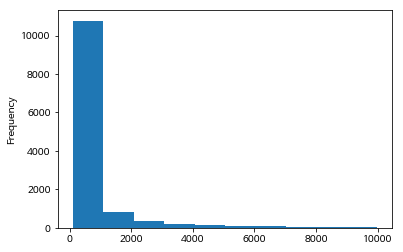

In [8]:
%matplotlib inline 
df['votes'].plot.hist()

# 투표수를 평균보다 높게 혹은 적게 받는지 예측해 보기

In [9]:
# 기본값을 0으로 세팅
df['votes_pos_neg'] = 0

In [10]:
# 평균 투표수를 구해 옵니다.
votes_mean = df['votes'].mean()
votes_mean

699.2142291237521

In [11]:
# 투표수가 평균을 넘으면 1로 다시 세팅합니다.
df['votes_pos_neg'] = (df['votes'] > votes_mean) == 1

In [12]:
# 타입을 boolean 에서 int로 변경해 줍니다.
df['votes_pos_neg'] = df['votes_pos_neg'].astype(int)

In [13]:
df.head()

,article_id,start,end,answered,votes,category,title,content,votes_pos_neg
7,28,2017-08-19,2017-08-26,0,2137,경제민주화,소액주주를 보호해주십시오,** 존경하옵는 문재인대통령님께\n저는 중국원양자원이라는 KOSPI상장사의 소액 ...,1
13,34,2017-08-19,2017-09-18,0,679,기타,『국가유공자 등 예우 및 지원에 관한법률』상「6.25전몰군경 자녀수당」의 불합리한 ...,(현황)\n우리들 아버지께서는 67여년전 북의 남침으로 조국이 위기에 처했을 때 젊...,0
16,37,2017-08-19,2017-09-18,0,415,기타,황우석박사님 연구재개 허용 촉구합니다.,국민의 70% 이상이 황우석박사님을 응원하고 지지하고 있습니다.\n*2007년 1월...,0
18,40,2017-08-19,2017-09-18,0,218,외교/통일/국방,국가유공자등 예우및 지우너에 관한 법률 시행령 개정,지금부터 67년전 1950년 6.25전쟁때 조국 대한민국이 위태로운 시점에 우리들 ...,0
19,41,2017-08-19,2017-09-18,0,227,외교/통일/국방,국가유공자등 예우및 지우너에 관한 법률 시행령 개정,지금부터 67년전 1950년 6.25전쟁때 조국 대한민국이 위태로운 시점에 우리들 ...,0


In [14]:
# 샘플로 보고 싶은 인덱스의 번호를 넣어주세요.
sample_index = 38

In [15]:
sample_title = df['title'][sample_index]
sample_title

'영어회화전문강사제도는 유지되어야합니다.'

In [16]:
sample_content = petitions['content'][sample_index]
sample_content

'1. 영전강의고용안정을 원합니다\\n2.1년단위계약직으로 임신 출산육아 매우 곤란합니다\\n3. 성과급 호봉인정 상여금 급식비지원 전혀없으며 연봉인상 또한 없습니다\\n4.인권위의 무기직으로 전환 권고받았습니다\\n5.공공부문 비정규직 없애는건 문정부의 공약이며 이에따라 영전강만 제외하는것은 불공평합니다\\n저희는 정교사나 정규직을 원하는것이 아닙니다.\\n이 일을 계속 하길 희망할 뿐입니다.  문재인대통령님께선 일자리창출을 매우 중요하게 생각하셨습니다.  일자리창출 만큼 중요한것이 일자리 유지입니다.  창출만 하고 유지가 되지 않는다면 그저  형식적인 정책일 뿐입니다. 하루빨리 결과가 나와  안정된 마음으로 일하고 싶습니다.  감사합니다.'

# 전처리 하기 

In [17]:
def preprocessing(text):
    # 개행문자 제거
    text = re.sub('\\\\n', ' ', text)
    # 특수문자 제거
    # 특수문자나 이모티콘 등은 때로는 의미를 갖기도 하지만 여기에서는 제거했습니다.
    # text = re.sub('[?.,;:|\)*~`’!^\-_+<>@\#$%&-=#}※]', '', text)
    # 한글, 영문, 숫자만 남기고 모두 제거하도록 합니다.
    # text = re.sub('[^가-힣ㄱ-ㅎㅏ-ㅣa-zA-Z0-9]', ' ', text)
    # 한글, 영문만 남기고 모두 제거하도록 합니다.
    text = re.sub('[^가-힣ㄱ-ㅎㅏ-ㅣa-zA-Z]', ' ', text)
    return text

In [18]:
# 불용어 제거
def remove_stopwords(text):
    tokens = text.split(' ')
    stops = ['안녕', '있습니다', '그', '년도', '안녕하세요', '하는', '및', '제', '할', '하고', '더', '대한', '한', '그리고', '월', '저는', '없는', '입니다', '등', '일', '많은', '이런', '것은', '왜','같은', '같습니다', '없습니다', '위해', '한다']
    meaningful_words = [w for w in tokens if not w in stops]
    return ' '.join(meaningful_words)

In [19]:
# 샘플데이터에 적용
pre_sample_content = preprocessing(sample_content)

In [20]:
pre_sample_content = remove_stopwords(pre_sample_content)

In [21]:
%time df['content_preprocessing'] = df['content'].apply(preprocessing)

CPU times: user 1.14 s, sys: 30 ms, total: 1.17 s
Wall time: 1.35 s


In [22]:
%time df['content_preprocessing2'] = df['content_preprocessing'].apply(remove_stopwords)

CPU times: user 1.79 s, sys: 35 ms, total: 1.83 s
Wall time: 1.96 s


# 학습세트와 테스트세트 만들기
* 학습세트와 테스트세트를 7:3의 비율로 나눠 줍니다.

In [23]:
df = df.reindex()

In [24]:
df.shape

(12622, 11)

In [25]:
split_count = int(df.shape[0] * 0.7)
split_count

8835

In [26]:
df_train = df[:split_count].copy()
df_train.shape

(8835, 11)

In [27]:
df_train.head()

,article_id,start,end,answered,votes,category,title,content,votes_pos_neg,content_preprocessing,content_preprocessing2
7,28,2017-08-19,2017-08-26,0,2137,경제민주화,소액주주를 보호해주십시오,** 존경하옵는 문재인대통령님께\n저는 중국원양자원이라는 KOSPI상장사의 소액 ...,1,존경하옵는 문재인대통령님께 저는 중국원양자원이라는 KOSPI상장사의 소액 주...,존경하옵는 문재인대통령님께 중국원양자원이라는 KOSPI상장사의 소액 주주입니...
13,34,2017-08-19,2017-09-18,0,679,기타,『국가유공자 등 예우 및 지원에 관한법률』상「6.25전몰군경 자녀수당」의 불합리한 ...,(현황)\n우리들 아버지께서는 67여년전 북의 남침으로 조국이 위기에 처했을 때 젊...,0,현황 우리들 아버지께서는 여년전 북의 남침으로 조국이 위기에 처했을 때 젊은...,현황 우리들 아버지께서는 여년전 북의 남침으로 조국이 위기에 처했을 때 젊은...
16,37,2017-08-19,2017-09-18,0,415,기타,황우석박사님 연구재개 허용 촉구합니다.,국민의 70% 이상이 황우석박사님을 응원하고 지지하고 있습니다.\n*2007년 1월...,0,국민의 이상이 황우석박사님을 응원하고 지지하고 있습니다 년 월 ...,국민의 이상이 황우석박사님을 응원하고 지지하고 년 중앙일보 여론...
18,40,2017-08-19,2017-09-18,0,218,외교/통일/국방,국가유공자등 예우및 지우너에 관한 법률 시행령 개정,지금부터 67년전 1950년 6.25전쟁때 조국 대한민국이 위태로운 시점에 우리들 ...,0,지금부터 년전 년 전쟁때 조국 대한민국이 위태로운 시점에 우리들 ...,지금부터 년전 년 전쟁때 조국 대한민국이 위태로운 시점에 우리들 ...
19,41,2017-08-19,2017-09-18,0,227,외교/통일/국방,국가유공자등 예우및 지우너에 관한 법률 시행령 개정,지금부터 67년전 1950년 6.25전쟁때 조국 대한민국이 위태로운 시점에 우리들 ...,0,지금부터 년전 년 전쟁때 조국 대한민국이 위태로운 시점에 우리들 ...,지금부터 년전 년 전쟁때 조국 대한민국이 위태로운 시점에 우리들 ...


In [28]:
# 학습 세트에서 투표수가 평균보다 많은 건
df_train.loc[df_train['votes_pos_neg'] == 1].shape

(1870, 11)

In [29]:
df_test = df[split_count:].copy()
df_test.shape

(3787, 11)

In [30]:
df_test.head()

,article_id,start,end,answered,votes,category,title,content,votes_pos_neg,content_preprocessing,content_preprocessing2
207904,268699,2018-06-11,2018-07-11,0,146,문화/예술/체육/언론,LG 트윈스 오지환 선수의 국가대표 발탁을 반대합니다,오지환 선수는 그동안 경찰청 팀에 입대하여 병역의 의무를 할 수 있었음에도 거부하...,0,오지환 선수는 그동안 경찰청 팀에 입대하여 병역의 의무를 할 수 있었음에도 거부하...,오지환 선수는 그동안 경찰청 팀에 입대하여 병역의 의무를 수 있었음에도 거부하였으...
207929,268729,2018-06-11,2018-07-11,0,194,행정,1.6 GDI 엔진결함 조사 과정과 결과를 공개해 주세요.,현대기아 자동차의 1.6 GDI 엔진결함 조사 과정과 결과를 공개해주시기 바랍니다....,0,현대기아 자동차의 GDI 엔진결함 조사 과정과 결과를 공개해주시기 바랍니다 ...,현대기아 자동차의 GDI 엔진결함 조사 과정과 결과를 공개해주시기 바랍니다 ...
207937,268738,2018-06-11,2018-07-11,0,3869,미래,정부가 암호화폐 투자하는 국민을 진심으로 걱정하고 있다면 해야 하는 것에 대한 청원,안녕하세요. 저는 40대 후반의 투자자입니다. 20대 후반부터 15년 정도 X-In...,1,안녕하세요 저는 대 후반의 투자자입니다 대 후반부터 년 정도 X In...,대 후반의 투자자입니다 대 후반부터 년 정도 X Internet 인...
207963,268771,2018-06-11,2018-07-11,0,209,인권/성평등,혜화역 시위에 관련된 것들을 청원합니다.,페미니스트들이 남녀성평등을 주장하며 남성혐오를 보여주고 있는 혜화역 시위는 유투브 ...,0,페미니스트들이 남녀성평등을 주장하며 남성혐오를 보여주고 있는 혜화역 시위는 유투브 ...,페미니스트들이 남녀성평등을 주장하며 남성혐오를 보여주고 있는 혜화역 시위는 유투브 ...
207974,268784,2018-06-11,2018-07-11,0,240,문화/예술/체육/언론,아시안게임 금메달리스트에게 주는 병역혜택 폐지 청원,국위선양이라는 이유로 올림픽 메달리스트와 아시안게임 금메달리스트 선수들에게 주어지는...,0,국위선양이라는 이유로 올림픽 메달리스트와 아시안게임 금메달리스트 선수들에게 주어지는...,국위선양이라는 이유로 올림픽 메달리스트와 아시안게임 금메달리스트 선수들에게 주어지는...


In [31]:
# 테스트 세트에서 투표수가 평균보다 많은 건
df_test.loc[df_test['votes_pos_neg'] == 1].shape

(738, 11)

# 단어 벡터화 하기

In [32]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer(analyzer = 'word', # 캐릭터 단위로 벡터화 할 수도 있습니다.
                             tokenizer = None, # 토크나이저를 따로 지정해 줄 수도 있습니다.
                             preprocessor = None, # 전처리 도구
                             stop_words = None, # 불용어 nltk등의 도구를 사용할 수도 있습니다.
                             min_df = 2, # 토큰이 나타날 최소 문서 개수로 오타나 자주 나오지 않는 특수한 전문용어 제거에 좋다. 
                             ngram_range=(1, 3), # BOW의 단위를 1~3개로 지정합니다.
                             max_features = 2000 # 만들 피처의 수, 단어의 수가 된다.
                            )
vectorizer

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=2000, min_df=2,
        ngram_range=(1, 3), preprocessor=None, stop_words=None,
        strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
        tokenizer=None, vocabulary=None)

In [33]:
%%time 
train_feature_vector = vectorizer.fit_transform(df_train['content_preprocessing2'])
train_feature_vector.shape

CPU times: user 21.6 s, sys: 949 ms, total: 22.5 s
Wall time: 23.8 s


In [34]:
%%time 
test_feature_vector = vectorizer.fit_transform(df_test['content_preprocessing2'])
test_feature_vector.shape

CPU times: user 11.1 s, sys: 508 ms, total: 11.6 s
Wall time: 12.5 s


In [35]:
vocab = vectorizer.get_feature_names()
print(len(vocab))
vocab[:10]

2000


['aid',
 'articleview',
 'articleview html',
 'articleview html idxno',
 'bmw',
 'cctv',
 'cctv를',
 'co',
 'co kr',
 'co kr news']

In [36]:
dist = np.sum(train_feature_vector, axis=0)

pd.DataFrame(dist, columns=vocab)

,aid,articleview,articleview html,articleview html idxno,bmw,cctv,cctv를,co,co kr,co kr news,...,휴게시간을,희망을,힘든,힘들게,힘들고,힘들어,힘듭니다,힘없는,힘을,힘이
0,115,159,96,295,280,120,556,85,95,90,...,216,184,292,202,86,98,100,149,256,152


In [37]:
from sklearn.feature_extraction.text import TfidfTransformer
transformer = TfidfTransformer(smooth_idf=False)
transformer

TfidfTransformer(norm='l2', smooth_idf=False, sublinear_tf=False,
         use_idf=True)

In [38]:
%%time 
train_feature_tfidf = transformer.fit_transform(train_feature_vector)
train_feature_tfidf.shape

CPU times: user 18.2 ms, sys: 7.89 ms, total: 26.1 ms
Wall time: 31.9 ms


In [39]:
%%time 
test_feature_tfidf = transformer.fit_transform(test_feature_vector)
test_feature_tfidf.shape

CPU times: user 9.49 ms, sys: 3.31 ms, total: 12.8 ms
Wall time: 11.3 ms


In [40]:
test_feature_tfidf.shape

(3787, 2000)

# 랜덤 포레스트로 학습시키기
* 공식문서 : http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html

In [41]:
from sklearn.ensemble import RandomForestClassifier

# 랜덤포레스트 분류기를 사용
forest = RandomForestClassifier(
    n_estimators = 100, n_jobs = -1, random_state=2018)
forest

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
            oob_score=False, random_state=2018, verbose=0,
            warm_start=False)

In [42]:
# 학습에 사용할 y_label 을 넣어준다.
y_label = df_train['votes_pos_neg']
%time forest = forest.fit(train_feature_tfidf, y_label)

CPU times: user 15.8 s, sys: 144 ms, total: 15.9 s
Wall time: 6.42 s


# 평가하기

In [43]:
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
k_fold = KFold(n_splits=5, shuffle=True, random_state=0)

scoring = 'accuracy'
score = cross_val_score(forest, train_feature_tfidf, y_label, cv=k_fold, n_jobs=-1, scoring=scoring)
score

array([0.778721  , 0.8024901 , 0.78268251, 0.79173741, 0.77192982])

In [44]:
round(np.mean(score)*100,2)

78.55

# 예측

In [45]:
# 테스트 데이터를 넣고 예측한다.
y_pred = forest.predict(test_feature_tfidf)
y_pred[:10]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [46]:
y_pred.shape

(3787,)

In [47]:
# 예측 결과를 저장하기 위해 데이터프레임에 담아 준다.
output = pd.DataFrame(data={'votes_pos_neg_pred':y_pred})
output.head()

,votes_pos_neg_pred
0,0
1,0
2,0
3,0
4,0


In [48]:
# 0과 1이 어떻게 집계 되었는지 확인한다.
# 실제 데이터에는 답변 대상 건이 있는데 없는 것으로 예측되었다.
output['votes_pos_neg_pred'].value_counts()

0    3778
1       9
Name: votes_pos_neg_pred, dtype: int64

In [49]:
df_test['votes_pos_neg_pred'] = y_pred

In [50]:
df_test['pred_diff'] = df_test['votes_pos_neg'] - df_test['votes_pos_neg_pred']
df_test.head()

,article_id,start,end,answered,votes,category,title,content,votes_pos_neg,content_preprocessing,content_preprocessing2,votes_pos_neg_pred,pred_diff
207904,268699,2018-06-11,2018-07-11,0,146,문화/예술/체육/언론,LG 트윈스 오지환 선수의 국가대표 발탁을 반대합니다,오지환 선수는 그동안 경찰청 팀에 입대하여 병역의 의무를 할 수 있었음에도 거부하...,0,오지환 선수는 그동안 경찰청 팀에 입대하여 병역의 의무를 할 수 있었음에도 거부하...,오지환 선수는 그동안 경찰청 팀에 입대하여 병역의 의무를 수 있었음에도 거부하였으...,0,0
207929,268729,2018-06-11,2018-07-11,0,194,행정,1.6 GDI 엔진결함 조사 과정과 결과를 공개해 주세요.,현대기아 자동차의 1.6 GDI 엔진결함 조사 과정과 결과를 공개해주시기 바랍니다....,0,현대기아 자동차의 GDI 엔진결함 조사 과정과 결과를 공개해주시기 바랍니다 ...,현대기아 자동차의 GDI 엔진결함 조사 과정과 결과를 공개해주시기 바랍니다 ...,0,0
207937,268738,2018-06-11,2018-07-11,0,3869,미래,정부가 암호화폐 투자하는 국민을 진심으로 걱정하고 있다면 해야 하는 것에 대한 청원,안녕하세요. 저는 40대 후반의 투자자입니다. 20대 후반부터 15년 정도 X-In...,1,안녕하세요 저는 대 후반의 투자자입니다 대 후반부터 년 정도 X In...,대 후반의 투자자입니다 대 후반부터 년 정도 X Internet 인...,0,1
207963,268771,2018-06-11,2018-07-11,0,209,인권/성평등,혜화역 시위에 관련된 것들을 청원합니다.,페미니스트들이 남녀성평등을 주장하며 남성혐오를 보여주고 있는 혜화역 시위는 유투브 ...,0,페미니스트들이 남녀성평등을 주장하며 남성혐오를 보여주고 있는 혜화역 시위는 유투브 ...,페미니스트들이 남녀성평등을 주장하며 남성혐오를 보여주고 있는 혜화역 시위는 유투브 ...,0,0
207974,268784,2018-06-11,2018-07-11,0,240,문화/예술/체육/언론,아시안게임 금메달리스트에게 주는 병역혜택 폐지 청원,국위선양이라는 이유로 올림픽 메달리스트와 아시안게임 금메달리스트 선수들에게 주어지는...,0,국위선양이라는 이유로 올림픽 메달리스트와 아시안게임 금메달리스트 선수들에게 주어지는...,국위선양이라는 이유로 올림픽 메달리스트와 아시안게임 금메달리스트 선수들에게 주어지는...,0,0


In [51]:
pred_diff = df_test['pred_diff'].value_counts()
pred_diff

 0    3040
 1     738
-1       9
Name: pred_diff, dtype: int64

In [52]:
print('전체 {}건의 데이터 중 {}건 예측'.format(y_pred.shape[0], pred_diff[0]))

전체 3787건의 데이터 중 3040건 예측


In [53]:
acc = ( pred_diff[0] / y_pred.shape[0] ) *100 
print('예측 비율 {}'.format(acc))

예측 비율 80.27462371270134
